In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

Стационарный ряд

In [41]:

passengers = pd.read_csv('/content/international-airline-passengers.csv')

Нестационарный ряд

In [42]:
births = pd.read_csv('/content/daily-total-female-births-in-cal.csv')

In [4]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n - 1] + (1 - alpha) * result[n - 1])
    if not n_pred:
        return pd.Series(result)
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]
    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    return pd.concat([series, pd.Series(predictions)])

In [5]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
        preds.append(level + trend)
    return pd.concat([series, pd.Series(preds)])

In [6]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [7]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [8]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [36]:
def graph(train, test, predict):
    _, ax = plt.subplots(figsize=(14, 6))
    ax.plot(train, c='gray', linestyle='-.', marker='.')
    ax.plot(test, c='silver', linestyle='-.', marker='.')
    ax.plot([i for i in range(len(train), len(train) + len(test))], predict[len(train):], c='r', marker='.')
    ax.legend(['Train', 'Test', 'Predicted'])
    plt.show()

***International airline passengers: monthly totals in thousands.***

 В данном ряду присутствует сезонность и тренд, поэтому<br>
для прогноза значений ряда, буду использовать тройное экспоненциальное сглаживание.<br>


Разделение на обучающую и тестовую выборки

In [10]:
train, test = passengers['Count'].iloc[:115], passengers['Count'].iloc[115:]

Подбор параметров

In [11]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [12]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds=((0, 1), (0, 1), (0, 1)))

Предсказание

In [13]:
alpha, beta, gamma = opt.x
predicted = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))

График

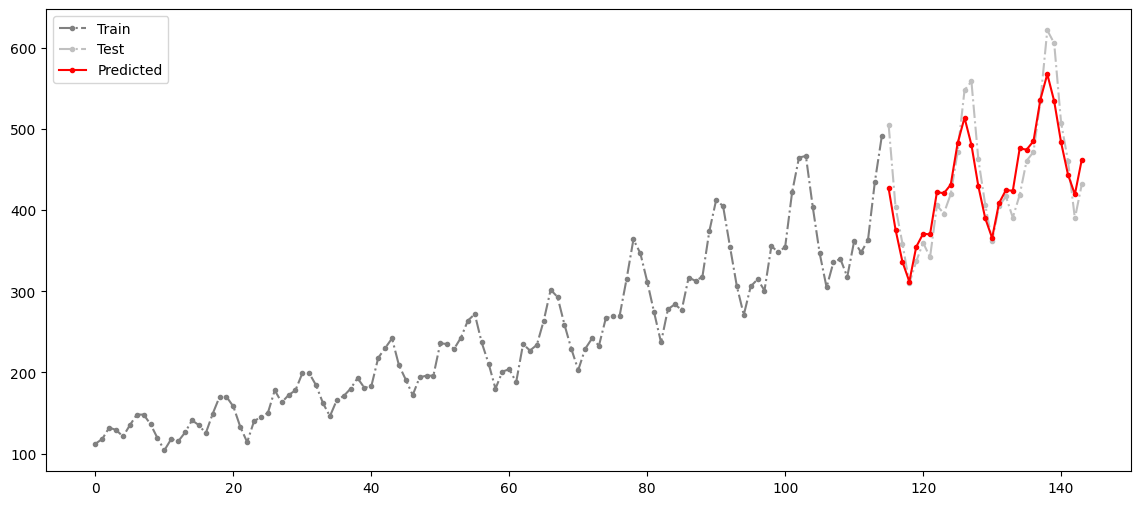

In [37]:
graph(train, test, predicted)

Оценка результатов

In [15]:
print(mean_squared_error(test, predicted[len(train):]))

1171.2695204139422



***Daily total female births in California.***

 В этом ряду отсутствует сезонность, есть слабовыраженный тренд, поэтому буду<br>
использовать двойное экспоненциальное сглаживание. Но попробую и другие сглаживания для сравнения.<br>


Разделение на обучающую и тестовую выборки

In [16]:
x, y = births['Count'].iloc[:325], births['Count'].iloc[325:]

*Экспоненциальное сглаживание<br>*


Предсказание

In [17]:
predicted1 = exponential_moving_average(x, 0.5, n_pred=len(y))
predicted1 = predicted1[:365]

График

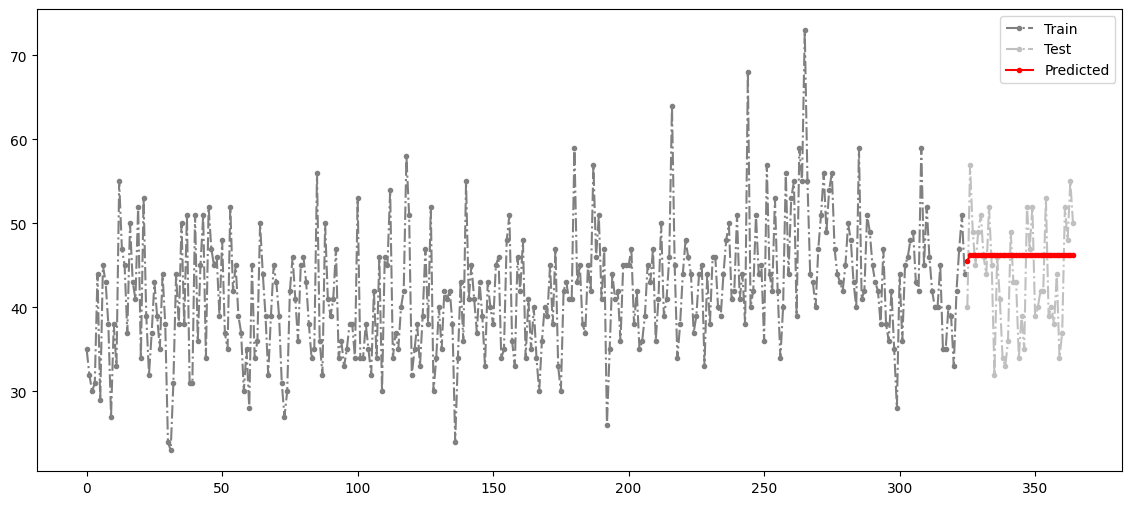

In [38]:
graph(x, y, predicted1)

Оценка результатов

In [19]:
print(mean_squared_error(y, predicted1[len(x):]))

50.22284952822856


*Двойное экспоненциальное сглаживание*

Подбор параметров

In [20]:
def mse(X):
    alpha, beta = X
    result = double_ema_with_preds(x, alpha, beta, births.shape[0] - len(x))
    predictions = result[-len(y):]
    error = mean_squared_error(predictions, y)
    return error

In [21]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds=((0, 1), (0, 1)))

Предсказание

In [22]:
predicted2 = double_ema_with_preds(x, alpha=opt.x[0], beta=opt.x[1], n_preds=len(y))

График

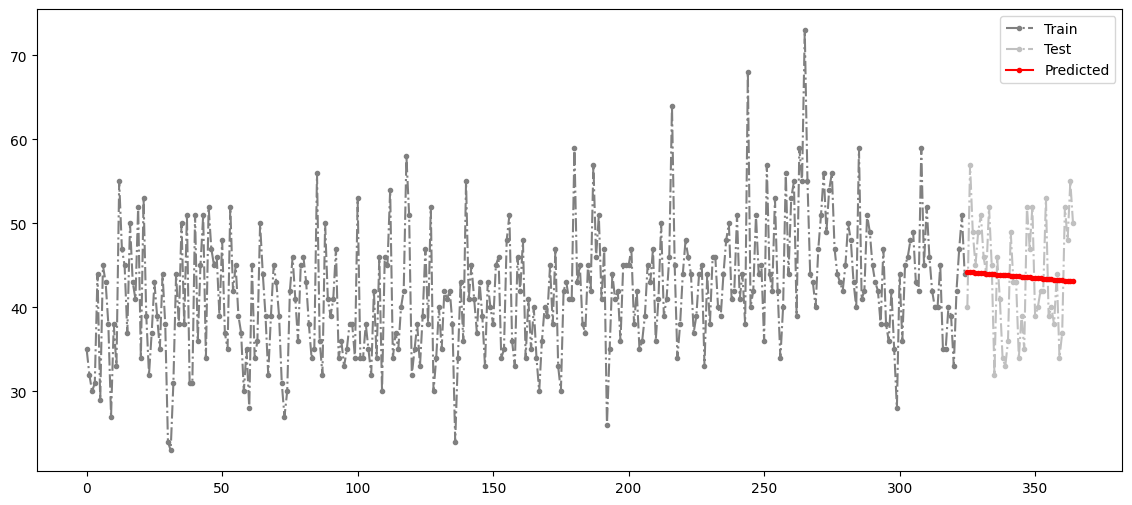

In [39]:
graph(x, y, predicted2)

Оценка результатов




In [24]:
print(mean_squared_error(y, predicted2[len(x):]))

43.754495778614604


*Тройное* экспоненциальное сглаживание

Подбор параметров

In [25]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(x, 12, alpha, beta, gamma, len(y))
    predictions = result[-len(y):]
    error = mean_squared_error(predictions, y)
    return error

In [26]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds=((0, 1), (0, 1), (0, 1)))

Предсказание

In [27]:
predicted3 = triple_exponential_smoothing(x, 12, opt.x[0], opt.x[1], opt.x[2], len(y))

График

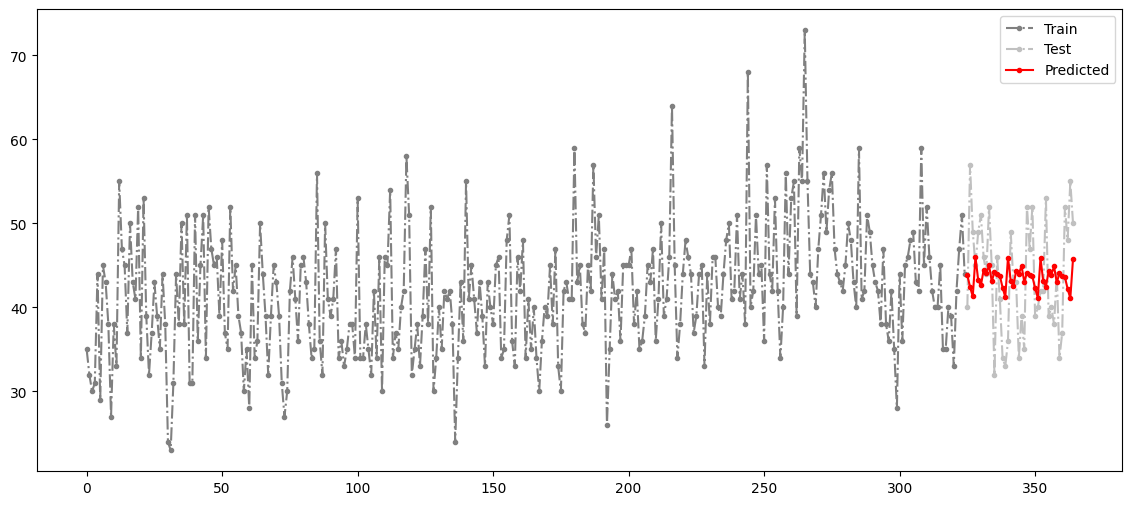

In [40]:
graph(x, y, predicted3)

Оценка результатов

In [29]:
print(mean_squared_error(y, predicted3[len(x):]))
pass

47.76873774457278


В итоге наилучшие результаты для 2-го временного ряда показал алгоритм 2-го эксп. сглаживания. Обычное эксп. сглаживание хуже из-за того что есть тренд. А 3-ое эксп. сглаживание хуже из-за того что нет сезонности.